Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [1]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
import pickle
import os.path
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
import time

## Folder dir for saving and loading files

In [2]:
model_folder = 'data/model/'
trajectory_folder = 'data/trajectory/'
optimal_trajectory_folder = 'data/optimal_trajectory/'

model_name = 'test_mtm'

---
# 2 - Robot modelling

## Create joint variables and define their relations

In [3]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9 = new_sym('q:10')
# define paralelogram coordinate relation
# q3 = -q2 + q4
# q5 = -q4 + q2

## Robot geometry definition in following order

| Joint number | prev link | succ links | $a$ | $\alpha$ | $d$ | $\theta$ | link inertia | motor inertia | friction |
|--------------|-----------|------------|-----|----------|-----|----------|--------------|---------------|---------|

In [4]:
# robot_def = RobotDef([(0,   -1, [1],    0, 0, 0, 0),
#                       (1,   0,  [2, 4], 0, 0, -0.21537, q1),
#                       (2,   1,  [3],    0, -sympy.pi/2, 0, q2+sympy.pi/2),
#                       (3,   2,  [],    0.279, 0, 0, q3+sympy.pi/2),
#                       (4,   1,  [5],    0, -sympy.pi/2, 0, q4+sympy.pi),
#                       (5,   4,  [],     0.1, 0, 0, q5-sympy.pi/2)],
#                      dh_convention='mdh',
#                      friction_type=['Coulomb', 'viscous', 'offset'])

name = 'mtm'

if (name == 'mtm'):
    robot_def = RobotDef([(0,   -1, [1],    0,      0,              0,          0,                  False, False, False),
                          (1,   0,  [2],    0,      0,              -0.21537,   q1,                 True,  False, True),
                          (2,   1,  [3],    0,      -sympy.pi/2,    0,          q2+sympy.pi/2,      True,  False, True),
                          (3,   2,  [4],    0.279,  0,              0,          q3 + sympy.pi / 2,  True,  True,  True)],
                         dh_convention='mdh',
                         friction_type=['Coulomb', 'viscous', 'offset'])

elif (name == 'psm'):
    robot_def = RobotDef([(0,   -1, [1],    0,      0,     0,          0,                     False, False, False),
                      (1,   0,  [2],   0,  sympy.pi/2,   0.5,   q1+sympy.pi/2,       True,  False, True),
                      (2,   1,  [3], 0.1, -sympy.pi/2,     0,   q2-sympy.pi/5,      True,  False, True),
                      (3,   2,  [4], 0.5,           0,     0,   -q2+sympy.pi/5+sympy.pi/2,    True,  False, True),
                      (4,   3,  [5],   1,           0,     0,    q2,                               True,  False, True),
                      (5,   4,  [6], 0.2, -sympy.pi/2,0.5+q3,    sympy.pi/2,        True,  False, True)],
                         dh_convention='mdh',
                         friction_type=['Coulomb', 'viscous', 'offset'])
    
elif( name == 'psm_long'):
    robot_def = RobotDef([(0,   -1, [1],    0,      0,     0,          0,                     False, False, False),
                      (1,   0,  [2],   0,  sympy.pi/2,   0.5,   q1+sympy.pi/2,       True,  False, True),
                      (2,   1,  [3], 0.1, -sympy.pi/2,     0,   q2-sympy.pi/5,      True,  False, True),
                      (3,   2,  [4], 0.5,           0,     0,   -q2+sympy.pi/5+sympy.pi/2,    True,  False, True),
                      (4,   3,  [5],   1,           0,     0,    q2,                               True,  False, True),
                      (5,   4,  [6], 0.2, -sympy.pi/2,0.5+q3,    sympy.pi/2,        True,  False, True),
                      (6,   5,  [7],   0,           0,   0.2,    -sympy.pi/2+q4,                True,  False, True),
                      (7,   6,[8,9], 0.5, -sympy.pi/2,     0,   -sympy.pi/2+q5,    False,  True, True),
                      (8,   7, [15], 0.3, -sympy.pi/2,     0,    -sympy.pi/2+q6-q7, False,  True, True),
                      (9,   7, [15], 0.3, -sympy.pi/2,     0,    -sympy.pi/2+q6+q7, False,  True, True),
                      (10,  2, [11],   0,           0,   0.5,    sympy.pi/5+sympy.pi/2,        False,  False, False),
                      (11, 10, [15],-0.5, +sympy.pi/2, 0.13*q3,    0, True,  False, True)],
                     dh_convention='mdh',
                     friction_type=['Coulomb', 'viscous', 'offset'])


In [5]:
robot_def.Ia

In [6]:
robot_def.std_params

In [7]:
robot_def.bary_params

## Create kinematics chain

In [8]:
geom = Geometry(robot_def)


[[0]
 [0]
 [0]]
[[0]
 [0]
 [-0.215370000000000]]
[[0]
 [0]
 [-0.215370000000000]]
[[-0.279*sin(1)*cos(1)]
 [-0.279*sin(1)**2]
 [-0.21537 - 0.279*cos(1)]]


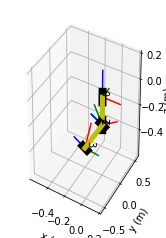

In [9]:
geom.draw_geom()

In [10]:
geom.T_0nc[2]

⎡                                                l2x⋅sin(q₂)⋅cos(q₁)   l2y⋅cos
⎢-sin(q₂)⋅cos(q₁)  -cos(q₁)⋅cos(q₂)  -sin(q₁)  - ─────────────────── - ───────
⎢                                                         m₂                  
⎢                                                                             
⎢                                                l2x⋅sin(q₁)⋅sin(q₂)   l2y⋅sin
⎢-sin(q₁)⋅sin(q₂)  -sin(q₁)⋅cos(q₂)  cos(q₁)   - ─────────────────── - ───────
⎢                                                         m₂                  
⎢                                                                             
⎢                                                          l2x⋅cos(q₂)   l2y⋅s
⎢    -cos(q₂)          sin(q₂)          0                - ─────────── + ─────
⎢                                                               m₂            
⎢                                                                             
⎣       0                 0             0           

## Create dynamics

In [11]:
%time dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating joint torques...
Adding frictions and motor rotor inertia...
Calculating gregressor...
('input_vars', (q1, q2, q3, dq1, dq2, dq3, ddq1, ddq2, ddq3))
Calculating M, C and G...
Calculating base parameter...
base parameter number: 25
Creating H_b function...
Finished creating robot dynamics
CPU times: user 1min 26s, sys: 224 ms, total: 1min 26s
Wall time: 1min 25s


In [12]:
dyn._calc_base_param()

Calculating base parameter...
base parameter number: 25
Creating H_b function...


In [13]:
sympy.Matrix(dyn.base_param)

⎡             1.0⋅l3x              ⎤
⎢                                  ⎥
⎢             1.0⋅l3y              ⎥
⎢                                  ⎥
⎢             1.0⋅L3xy             ⎥
⎢                                  ⎥
⎢             1.0⋅L3xz             ⎥
⎢                                  ⎥
⎢        1.0⋅l2x + 0.279⋅m₃        ⎥
⎢                                  ⎥
⎢             1.0⋅l2y              ⎥
⎢                                  ⎥
⎢             1.0⋅L2xy             ⎥
⎢                                  ⎥
⎢             1.0⋅L3yz             ⎥
⎢                                  ⎥
⎢       -1.0⋅L3xx + 1.0⋅L3yy       ⎥
⎢                                  ⎥
⎢             1.0⋅L2yz             ⎥
⎢                                  ⎥
⎢             1.0⋅L3zz             ⎥
⎢                                  ⎥
⎢       1.0⋅L2xz - 0.279⋅l3z       ⎥
⎢                                  ⎥
⎢-1.0⋅L2xx + 1.0⋅L2yy + 0.077841⋅m₃⎥
⎢                                  ⎥
⎢             1.0⋅Fv₁              ⎥
⎢

In [32]:
from robot_model_data import RobotModel
import numpy
import dill as pickle
robot_model = RobotModel(dyn)
#robot_model.save_model(model_folder,model_name)

model_file = model_folder + model_name
with open(model_file, 'wr') as f:
    pickle.dump(robot_model, f, pickle.HIGHEST_PROTOCOL)

---
# 3 - Excitation trajectory optimization

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [19]:
base_freq = 0.1
fourier_order = 6

traj_optimizer = TrajOptimizer(dyn, fourier_order, base_freq,
                               joint_constraints=[(q1, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                                                  (q2, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi)],cartesian_constraints = [(1,'max',1,0.4,1),(1,'min',-1,-1,-1) ])
                                                                                                                      
                                                                                                                     
traj_optimizer.optimize()


joint constraint number: 2
cartesian constraint number: 2
constraint number: 20
frames_constrained: [1.]
Condition number: 23.5264184694
x: [ 0.11816891  0.12594607  0.18552752 -0.94568686  0.59183941  0.24945565
 -0.62375823  0.37645822  0.23659995  0.05678709 -0.24148694 -0.30290188
  0.82091686  0.09113192  0.79400486  0.47495658  0.06949082  0.85883373
 -0.694431    0.41009078  0.36470593  0.04682088  0.88432031 -0.33246233
  0.47642719  0.90673116  3.12360955  1.          0.92045243  0.7033156
 -0.11502859 -0.94303631  0.48363651  0.3287557   0.99978125 -0.36504429
 -0.32094186 -0.37587332 -0.20110128]

SLSQP Solution to Optimial Excitation Trajectory

        Objective Function: _obj_func

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                   12.7292
    Total Function Evaluations:          
    Sensitivities:        FD

    Objectives:
        Name        Value        Optimum
	     f         23.5264     

## Plot optimal excitation trajectory

In [21]:
traj_optimizer.calc_frame_traj()
#print(traj_optimizer.frame_traj[0])

<function <lambda> at 0x7fe0ac6cb410>
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0.       0.      -0.21537]
[ 0. 

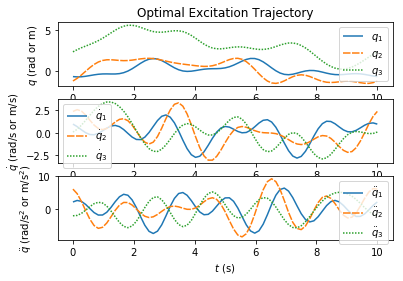

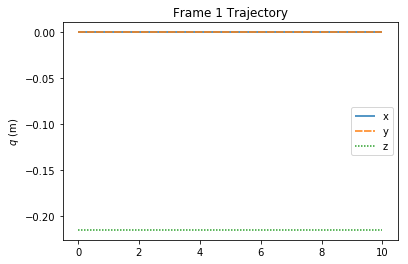

In [22]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj,traj_optimizer.frame_traj, traj_optimizer.const_frame_ind)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

traj_plotter.plot_frame_traj(True)

## Save trajectory for later use

In [23]:
dof_order_bf_x = (traj_optimizer.fourier_traj.dof, fourier_order, base_freq, traj_optimizer.x_result)


In [28]:

dof_order_bf_x_file_name = 'optimal_traj1.pkl'
dof_order_bf_x_dir = optimal_trajectory_folder + dof_order_bf_x_file_name

#if not os.path.exists(dof_order_bf_x_dir):
with open(dof_order_bf_x_dir, 'wr') as f:
    pickle.dump(dyn.H_b, f)

---
# Data processing

In [404]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

## Load data

In [405]:
trajectory_data_file = trajectory_folder + 'test.csv'
trajectory_sampling_rate = 200
t, q_raw, tau_raw = load_trajectory_data(trajectory_data_file, trajectory_sampling_rate)
dof = q_raw.shape[1]

(<type 'numpy.ndarray'>, (6000, 6))


## Calculate filter cut-off frequency

In [406]:
fc_mult = 10.0
wf = 0.1
order = 5
fc = wf * order * fc_mult
print("cut frequency is {}".format(fc))

cut frequency is 5.0


## Get velocity and acceleration data and filter raw data

q_raw shape: (6000, 3)
0
1
2
plot shape: 430


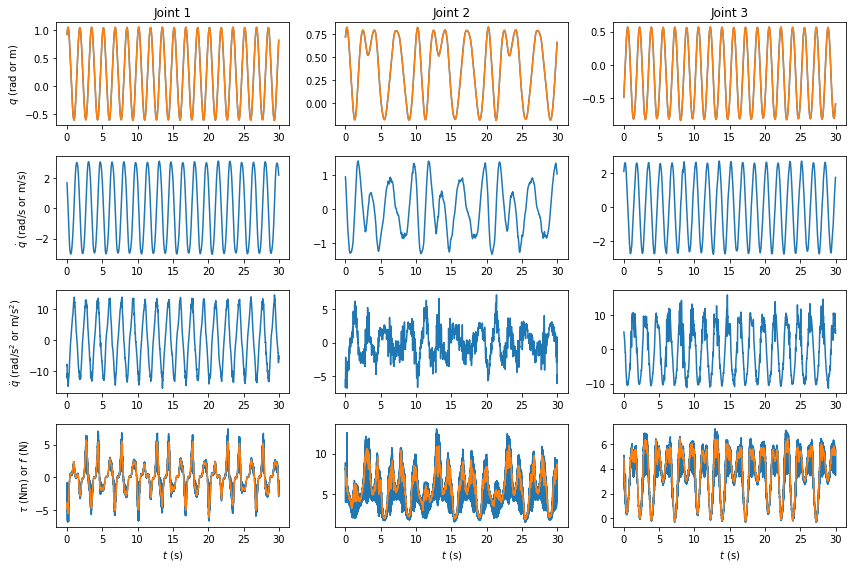

In [407]:
t_cut, q_f, dq_f, ddq_f, tau_f, q_raw_cut, tau_raw_cut = diff_and_filt_data(dof, 1.0/trajectory_sampling_rate, t,
                                                                        q_raw, tau_raw, fc, fc, fc, fc)
plot_trajectory_data(t_cut, q_raw_cut, q_f, dq_f, ddq_f, tau_raw_cut, tau_f)

In [408]:
traj_optimizer.x_result

array([0.19527456, 0.05499636, 0.01257543, 0.01762566, 0.05308366,
       0.07172092, 0.0436393 , 0.08849827, 0.03216644, 0.04955564,
       0.02840527, 0.01617652, 0.05232875, 0.2520678 , 0.02409019,
       0.03968145, 0.08851203, 0.03258817, 0.04853403, 0.03247351,
       0.01148666, 0.06258824, 0.09839208, 0.04882816, 0.01725808,
       0.02858661, 0.10635061, 0.06876134, 0.03093529, 0.06388051,
       0.02206364, 0.05590925, 0.01469899, 0.03005646, 0.07760879,
       0.06171671, 0.01335202, 0.04515137, 0.07481901])

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [409]:
base_param_num = dyn.base_num
H_b_func = dyn.H_b_func
W_b, tau_s = gen_regressor(base_param_num, H_b_func, q_f, dq_f, ddq_f, tau_f)

In [410]:
print(W_b.shape, tau_s.shape)

((17970, 25), (17970,))


In [411]:
xb_ols = np.linalg.lstsq(W_b, tau_s)[0]

/home/yan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [412]:
sympy.Matrix.hstack(sympy.Matrix(dyn.base_param), sympy.Matrix(xb_ols))

⎡                  1.0⋅l3y                      0.0853484882631891  ⎤
⎢                                                                   ⎥
⎢                  1.0⋅l3x                       0.44070034017683   ⎥
⎢                                                                   ⎥
⎢                  1.0⋅L3xy                     -0.0199560806744156 ⎥
⎢                                                                   ⎥
⎢                  1.0⋅L3xz                    -0.000261415414369348⎥
⎢                                                                   ⎥
⎢                  1.0⋅l2y                      -0.0154761436352743 ⎥
⎢                                                                   ⎥
⎢             1.0⋅l2x + 0.279⋅m₃                 0.834550933086788  ⎥
⎢                                                                   ⎥
⎢                  1.0⋅L3yz                     0.00177751777570878 ⎥
⎢                                                                   ⎥
⎢                  1

## Compare measured torque and predicted torque

### Generate predicted torque

In [413]:
tau_p = np.zeros(tau_f.shape)
tau_ps = W_b.dot(xb_ols)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof]

### Evaluate regression

In [414]:
var_regression_error_ols = np.linalg.norm(tau_ps - tau_s) / (tau_ps.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols * np.linalg.inv(W_b.transpose().dot(W_b))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.002262231119234351
standard deviation of xb using OLS:
[2.75635478e-04 3.67191305e-04 7.66934020e-05 9.35639086e-05
 1.88995652e-03 8.13867056e-04 1.84915678e-04 1.82613200e-04
 1.80714236e-04 2.59991381e-04 1.39036811e-04 1.97510244e-04
 4.68303114e-04 7.35977160e-04 1.15824303e-03 1.68869485e-03
 1.65652930e-04 4.39369499e-04 4.86625300e-04 3.19810392e-03
 1.83817954e-02 6.14692331e-04 1.35852300e-03 1.55279813e-03
 1.40211505e-03]
percentage of standard deviation of xb using OLS: 
[3.22952971e-03 8.33199504e-04 3.84310944e-03 3.57912745e-01
 1.22120637e-01 9.75215560e-04 1.04030284e-01 4.71685113e-01
 1.72551885e-03 2.50815397e-01 1.04417594e-03 4.11679070e-01
 1.76094669e-03 2.25973323e-01 5.98229453e-02 1.10583881e-01
 1.37504654e-02 1.39160314e-03 2.71764499e-03 2.81143785e-02
 4.80785930e-02 9.68941329e-02 3.01286191e+00 1.63342137e-01
 6.80939392e-02]


### Plot measured torque and predicted torque

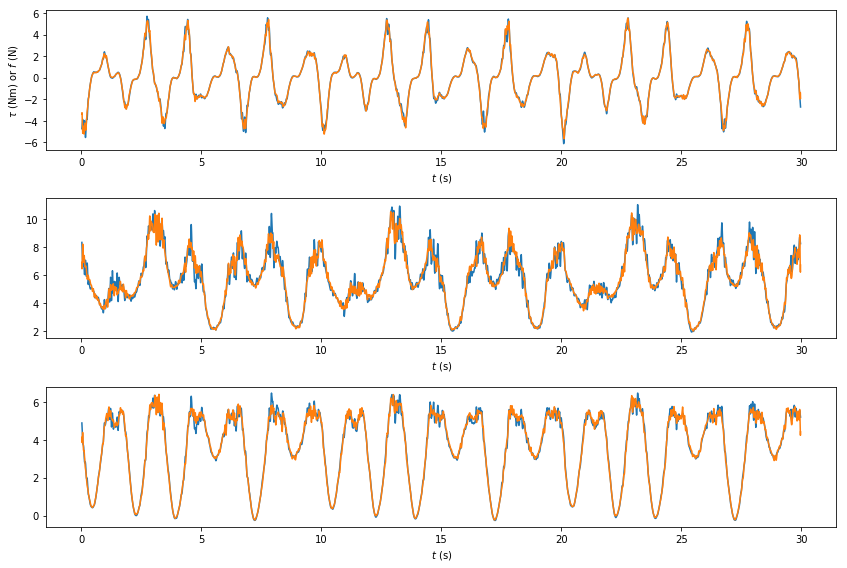

In [415]:
plot_meas_pred_tau(t_cut, tau_f, tau_p)

## Weighted Least Square (WLS)

## Convex optimization

In [416]:
# #from identification import SDPOpt
# import cvxpy as cp

# # sdp_opt = SDPOpt(W_b, tau_s, None)
# # sdp_opt.solve()
# m, n = W_b.shape
# sdp_x = cp.Variable(n)
# sdp_obj = cp.Minimize(cp.sum_squares(W_b*sdp_x - tau_s))
# sdp_constraints = []
# sdp_prob = cp.Problem(sdp_obj, sdp_constraints)

# result = sdp_prob.solve(solver=cp.OSQP)

# print(sdp_x.value)

In [417]:
# xb_ols

### Generate regressor matrix for barycentric parameters

In [418]:
from identification import SDPOpt

bary_param_num = len(robot_def.bary_params)
H_func = dyn.H_func
W, tau_s = gen_regressor(bary_param_num, H_func, q_f, dq_f, ddq_f, tau_f)

In [419]:
len(robot_def.std_params)

| min mass | max mass | min $r_x$ | max $r_x$ | min $r_y$ | max $r_y$ | min $r_z$ | max $r_z$ | max $F_c$ | max $F_v$ | max $F_o$ |
|----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|--------------|-----------|

In [438]:
# constraint order: (min_m, max_m, min_x, max_x, min_y, max_y, min_z, max_z)
# sdp_constraints = [(1, 10, -0.05, 0.05, 0, 0.1, 0, 0.2),
#                   (0.5, 3, -0.1, 0.1, -0.1, 0.1, -0.05, 0.05),
#                   (0.5, 5, 0, 0.3, 0, 0.1, -0.05, 0.05),
#                   (0.5, 5, -0.1, 0.1, 0, 0.1, -0.1, 0.1),
#                   (0.1, 1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1),]
sdp_constraints = [(1, 10, -0.05, 0.05, 0, 0.1, 0, 0.2),
                  (0.5, 10, -0.2, 0.2, -0.2, 0.2, -0.05, 0.05),
                  (0.5, 10, 0, 0.3, 0, 0.1, -0.05, 0.05)]

sdp_constraints = [(0.1, 3, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, 0.01, 0.01, 0.01),
                  (0.1, 2, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, 0.01, 0.01, 0.01),
                  (0.1, 3, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, 0.01, 0.01, 0.01)]

In [449]:
sdp_opt_std = SDPOpt(W, tau_s, robot_def, sdp_constraints)
sdp_opt_std.solve()

Regressor shape: (17970, 40)
Regressand shape: (17970,)
Creating variables...
Creating optimization objective...
Creating constraints...
Ia3 param40
Solving problem...
[ 5.05157530e-06  0.00000000e+00  0.00000000e+00  5.05157530e-06
  0.00000000e+00  1.02108036e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.02071477e+00  1.15895093e-03  6.21840659e-03
  6.26570024e-03  1.67755578e-02  1.27925954e-03  1.00170093e-03
  1.49382530e-01  5.05202474e-04  1.25564813e-01  3.99821648e-01
  1.34143500e-03 -7.32894362e-03  2.99833904e+00  6.44719777e-03
  5.86822387e-03  9.35162312e-03  3.26099717e-02 -2.06679592e-02
 -1.12187160e-03  1.36212925e-01  1.26943427e-03  1.24637033e-01
  4.52904765e-01  7.95053301e-02  2.86738199e-03  1.69236069e+00
  1.27773209e-02  2.59187699e-03 -2.03872023e-03  7.51053726e-04]


In [450]:
len(sdp_opt_std._constraints)

## Compare measured torque and predicted torque

### Generate predicted torque

In [451]:
tau_sdp_p = np.zeros(tau_f.shape)
tau_sdp_ps = W.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_sdp_p[:, i] = tau_sdp_ps[i::dof]

### Plot measured torque and predicted torque

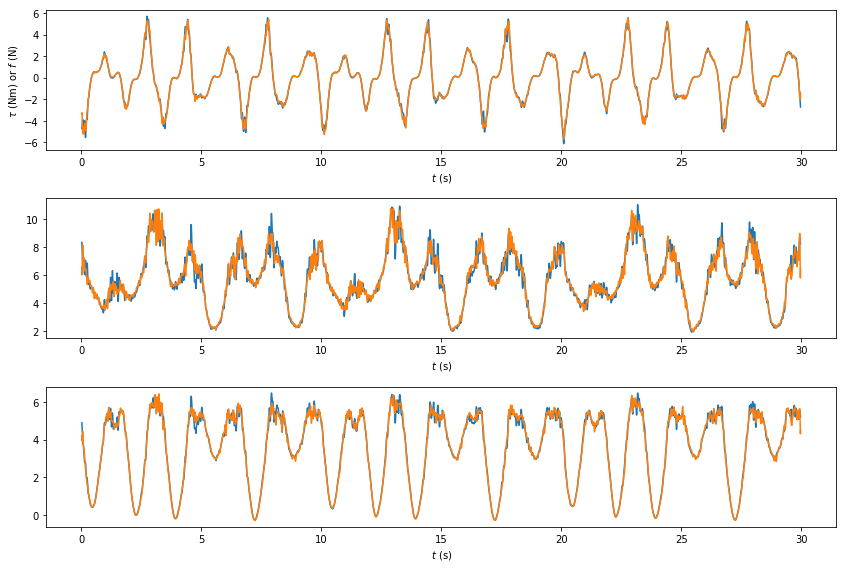

In [452]:
plot_meas_pred_tau(t_cut, tau_f, tau_sdp_p)

In [453]:
sympy.Matrix.hstack(sympy.Matrix(robot_def.bary_params), sympy.Matrix(sdp_opt_std.x_result))

⎡L1xx   5.0515752953477e-6 ⎤
⎢                          ⎥
⎢L1xy          0.0         ⎥
⎢                          ⎥
⎢L1xz          0.0         ⎥
⎢                          ⎥
⎢L1yy   5.0515752953477e-6 ⎥
⎢                          ⎥
⎢L1yz          0.0         ⎥
⎢                          ⎥
⎢L1zz  1.02108036407696e-5 ⎥
⎢                          ⎥
⎢l1x           0.0         ⎥
⎢                          ⎥
⎢l1y           0.0         ⎥
⎢                          ⎥
⎢l1z           0.0         ⎥
⎢                          ⎥
⎢ m₁     1.02071477395933  ⎥
⎢                          ⎥
⎢Fc₁   0.00115895092672477 ⎥
⎢                          ⎥
⎢Fv₁   0.00621840659410154 ⎥
⎢                          ⎥
⎢Fo₁   0.00626570024366565 ⎥
⎢                          ⎥
⎢L2xx   0.0167755578155568 ⎥
⎢                          ⎥
⎢L2xy  0.00127925953695484 ⎥
⎢                          ⎥
⎢L2xz  0.00100170093195651 ⎥
⎢                          ⎥
⎢L2yy   0.149382530242033  ⎥
⎢                          ⎥
⎢L2yz  0.00050

In [347]:
from identification import barycentric2standard_params

In [348]:
sdp_opt_std.x_result

array([ 4.88379053e-06,  0.00000000e+00,  0.00000000e+00,  4.88379053e-06,
        0.00000000e+00,  9.05229732e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.67703725e+00, -9.84366931e-04,  5.93306052e-03,
        6.27378514e-03,  4.32257387e-02,  5.63393150e-04,  5.75879517e-04,
        1.65800991e-01,  3.10236264e-03,  4.97410477e-02,  3.39709860e-01,
        2.93133382e-02, -1.50690826e-02,  1.00001805e+01,  1.86565173e-02,
        6.84630466e-03, -5.33463666e-02,  4.53536915e-03, -2.08481849e-02,
       -6.38476214e-04,  1.12046457e-01,  1.27563181e-03,  1.31691687e-01,
        4.38862689e-01,  7.48291301e-02,  9.27128827e-04,  1.82190038e+00,
        2.12205966e-02,  5.89319146e-04,  1.11663882e-01])

In [349]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_def)

In [350]:
sympy.Matrix.hstack(sympy.Matrix(robot_def.std_params), sympy.Matrix(x_std))

⎡I1xx   4.88379052810528e-6 ⎤
⎢                           ⎥
⎢I1xy            0          ⎥
⎢                           ⎥
⎢I1xz            0          ⎥
⎢                           ⎥
⎢I1yy   4.88379052810528e-6 ⎥
⎢                           ⎥
⎢I1yz            0          ⎥
⎢                           ⎥
⎢I1zz   9.05229732313068e-5 ⎥
⎢                           ⎥
⎢r1x            0.0         ⎥
⎢                           ⎥
⎢r1y            0.0         ⎥
⎢                           ⎥
⎢r1z            0.0         ⎥
⎢                           ⎥
⎢ m₁     3.67703725260028   ⎥
⎢                           ⎥
⎢Fc₁   -0.000984366931223852⎥
⎢                           ⎥
⎢Fv₁    0.00593306051763905 ⎥
⎢                           ⎥
⎢Fo₁    0.0062737851365104  ⎥
⎢                           ⎥
⎢I2xx   0.0431171057110954  ⎥
⎢                           ⎥
⎢I2xy   0.00155917818025668 ⎥
⎢                           ⎥
⎢I2xz   6.39771608606151e-5 ⎥
⎢                           ⎥
⎢I2yy    0.154238213165703  ⎥
⎢         